# Inputs

In [1]:
splitPartCount = 5
splitSeed = 27
hoursPerWindow = 1

# Preproccess

## read data

In [2]:
from utils.class_patient import Patients


patients = Patients.loadPatients()
len(patients)

1213

## remove missing

In [3]:
# fill measures whose null represent false value

from constants import NULLABLE_MEASURES


nullableMeasures = NULLABLE_MEASURES

for measureName in nullableMeasures:
    patients.fillMissingMeasureValue(measureName, 0)

In [4]:
# remove measures with less than 80% of data

measures = patients.getMeasures()

for measure, count in measures.items():
    if count < len(patients) * 80 / 100:
        patients.removeMeasures([measure])
        print(measure, count)

pco2 917
ph 954
po2 917
albumin 406
hba1c 326
lymphocyte 446
height 415
urine-ketone 294
crp 19


In [5]:
# remove patients with less than 80% of data

patients.removePatientByMissingFeatures()
len(patients)

1206

In [6]:
# # remove patients with positive tag in first 12 hours

from pandas import Timedelta


patients.removePatientAkiEarly(Timedelta(hours=12))

82

In [7]:
print("Total ", len(patients))
print("AKI ", sum([1 for p in patients if p.akdPositive]))
print("Ratio ", sum([1 for p in patients if p.akdPositive]) / len(patients))

Total  1124
AKI  392
Ratio  0.3487544483985765


## split patients

In [8]:
splitedPatients = patients.split(splitPartCount, splitSeed)

len(splitedPatients[0])

225

In [9]:
splitedPatients = patients.split(splitPartCount, splitSeed)


def trainTest():
    for i in range(splitedPatients.__len__()):
        testPatients = splitedPatients[i]

        trainPatientsList = splitedPatients[:i] + splitedPatients[i + 1 :]
        trainPatients = Patients(patients=[])
        for trainPatientsElem in trainPatientsList:
            trainPatients += trainPatientsElem

        yield trainPatients, testPatients


def trainValTest():
    for i in range(splitedPatients.__len__()):
        testPatients = splitedPatients[i]

        trainPatientsList = splitedPatients[:i] + splitedPatients[i + 1 :]
        trainPatients = Patients(patients=[])
        for trainPatientsElem in trainPatientsList:
            trainPatients += trainPatientsElem

        *trainPatients, valPatients = trainPatients.split(5, 27)
        tmpPatients = Patients(patients=[])
        for trainPatientsElem in trainPatients:
            tmpPatients += trainPatientsElem
        trainPatients = tmpPatients

        yield trainPatients, valPatients, testPatients

In [10]:
for trainPatients, testPatients in trainTest():
    print(len(trainPatients.patientList), len(testPatients.patientList))

899 225
899 225
899 225
899 225
900 224


# Transformer

### Seperate static and dynamic

In [11]:
import math
import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    LSTM,
    Dense,
    Dropout,
    Input,
    Concatenate,
    LayerNormalization,
    Conv1D,
    GlobalAveragePooling1D,
    BatchNormalization,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from official.nlp.modeling.models import TransformerEncoder


@keras.saving.register_keras_serializable()
class SplitTransfomer(Model):

    def __init__(self, timeSteps, timeFeatures, staticFeatures, **kwargs):
        super().__init__(**kwargs)

        self.timeSteps = timeSteps
        self.timeFeatures = timeFeatures
        self.staticFeatures = staticFeatures

        # time series layers
        self.transformerEncoder = TransformerEncoder(
            dropout_rate=0.1,
            attention_dropout_rate=0.1,
            # max_sequence_length=max_sequence_length,
            # vocab_size=vocab_size,
        )
        self.pooling = GlobalAveragePooling1D()

        # static layers
        self.stDense = Dense(staticFeatures, activation="relu")

        # combine layers
        self.concat = Concatenate(axis=1)
        self.drop = Dropout(0.2)
        self.dense1 = Dense(16, activation="relu")
        self.denseOut = Dense(1, activation="sigmoid")

        pass

    def call(self, input, training=False):
        seriesInputLayer, staticInputLayer = input

        # series
        seriesLayer = seriesInputLayer
        seriesLayer = self.transformerEncoder(seriesLayer, training=training)
        seriesLayer = self.pooling(seriesLayer)

        # static
        staticLayer = staticInputLayer

        combined = tf.concat([seriesLayer, staticLayer], axis=-1)
        combined = self.denseOut(combined)

        return combined

    def build(self, input_shape):
        seriesInputLayer, staticInputLayer = input_shape

        self.transformerEncoder.build(seriesInputLayer)

        super().build(input_shape)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "timeSteps": self.timeSteps,
                "timeFeatures": self.timeFeatures,
                "staticFeatures": self.staticFeatures,
            }
        )
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


def createModel2(timeSteps, timeFeatures, staticFeatures, model=None):
    if model is None:
        model = SplitTransfomer(timeSteps, timeFeatures, staticFeatures)
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss="binary_crossentropy",
        metrics=["AUC", "accuracy", "precision", "recall"],
    )

    return model


x = createModel2(24, 10, 10)
sample_series_input = tf.random.normal([1, 12, 31])  # (batch_size, timeSteps, timeFeatures)
sample_static_input = tf.random.normal([1, 67])  
_ = x([sample_series_input, sample_static_input])
x.summary(expand_nested=True, show_trainable=True)

2024-08-28 21:43:18.288541: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-28 21:43:18.295807: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-28 21:43:18.302602: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-28 21:43:18.305018: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-28 21:43:18.311645: I tensorflow/core/platform/cpu_feature_guar

Model: "split_transfomer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ global_average_pooling1d    │ (1, 31)               │          0 │   -   │
│ (GlobalAveragePooling1D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ ?                     │          0 │   -   │
│                             │                       │  (unbuilt) │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ concatenate (Concatenate)   │ ?                     │          0 │   -   │
│                             │                       │  (unbuilt) │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ ?                     │          0 │   -   │
│                             │                       │  (unbuilt) │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_1 (Dense)             │ ?                     │          0 │   -   │
│                             │                       │  (unbuilt) │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_2 (Dense)             │ (1, 1)                │         99 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 99 (396.00 B)

 Trainable params: 99 (396.00 B)

 Non-trainable params: 0 (0.00 B)

In [12]:
import pickle
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from utils.prepare_data import DeepLearningDataPreparer, trainValTestPatients
from utils.class_voter import combineProbas
from constants import TEMP_PATH
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping


loses = []
aucs = []
accuracies = []
precisions = []
recals = []

train_loss_list = []
val_loss_list = []

y_probas = []

for i, (trainValGenerator, testPatients) in enumerate(trainValTestPatients(patients, splitSeed)):
    models = []
    probas = []
    for ii, (trainPatients, valPatients) in enumerate(trainValGenerator):
        preparer = DeepLearningDataPreparer(
            hoursPerWindows=hoursPerWindow,
            fromHour=0,
            toHour=12,
        )

        cacheFile = TEMP_PATH / f"dl_train_data/{i}_{ii}.pkl"
        cacheFile.parent.mkdir(parents=True, exist_ok=True)

        if cacheFile.exists():
            (
                (npTrainX, staticTrainX, trainY),
                (npValX, staticValX, valY),
                (npTestX, staticTestX, testY),
            ) = pickle.loads(cacheFile.read_bytes())
        else:
            npTrainX, staticTrainX, trainY = preparer.fit_transform(trainPatients)
            npValX, staticValX, valY = preparer.transform(valPatients)
            npTestX, staticTestX, testY = preparer.transform(testPatients)
            cacheFile.write_bytes(
                pickle.dumps(
                    (
                        (npTrainX, staticTrainX, trainY),
                        (npValX, staticValX, valY),
                        (npTestX, staticTestX, testY),
                    )
                )
            )

        neg, pos = np.bincount(trainY)
        weight0 = (1 / neg) * (len(trainY)) / 2.0
        weight1 = (1 / pos) * (len(trainY)) / 2.0
        weight = {0: weight0, 1: weight1}

        early_stopping = EarlyStopping(
            monitor="val_loss", patience=250, restore_best_weights=True
        )

        model = createModel2(npTrainX.shape[1], npTrainX.shape[2], staticTrainX.shape[1])

        history = model.fit(
            [npTrainX, staticTrainX],
            np.array(trainY),
            epochs=5000,
            batch_size=32,
            validation_data=([npValX, staticValX], np.array(valY)),
            class_weight=weight,
            callbacks=[early_stopping],
            verbose=0,
        )
        train_loss_list.append(history.history["loss"])
        val_loss_list.append(history.history["val_loss"])
        probas.append(model.predict([npTestX, staticTestX]))
        model.save(f"result/transformer_split_model_{i}_{ii}.keras")

    # calculate final probas, auc, accuracy, precision, recal
    finalYProbas = np.apply_along_axis(combineProbas, 0, np.array(probas))

    finalAuc = roc_auc_score(testY, finalYProbas)
    aucs.append(finalAuc)

    y_pred = np.where(finalYProbas >= 0.5, 1, 0)

    accuracies.append(accuracy_score(testY, y_pred))
    precisions.append(precision_score(testY, y_pred))
    recals.append(recall_score(testY, y_pred))

    pass

I0000 00:00:1724856201.990586 2457150 service.cc:146] XLA service 0x796aec02dc60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724856201.990602 2457150 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2024-08-28 21:43:22.036001: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-28 21:43:22.061023: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:61] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. split_transfomer_1_1/transformer_encoder_1/layer_0/self_attention/dropout_3/dropout/random_uniform/RandomUniform
2024-08-28 21:43:22.437710: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-08-28 21:43:22.873085: I external

1/8 ━━━━━━━━━━━━━━━━━━━━ 3s 532ms/step

2024-08-28 21:44:43.683242: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 416 bytes spill stores, 408 bytes spill loads

2024-08-28 21:44:43.724201: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 12 bytes spill stores, 12 bytes spill loads



8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step


2024-08-28 22:02:44.505355: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 20 bytes spill stores, 20 bytes spill loads

2024-08-28 22:02:44.633208: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 236 bytes spill stores, 236 bytes spill loads



7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step  


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  


In [13]:
# print("Loses:", loses, np.mean(loses), np.std(loses))
print("AUCs:", aucs, np.mean(aucs), np.std(aucs))
print("Accuracies:", accuracies, np.mean(accuracies), np.std(accuracies))
print("Precisions:", precisions, np.mean(precisions), np.std(precisions))
print("Recals:", recals, np.mean(recals), np.std(recals))

Loses: [] nan nan
AUCs: [0.8362986220129077, 0.8044653758939473, 0.8148950927692041, 0.824172013178429, 0.7975061468212153] 0.8154674501351407 0.013810784097027597
Accuracies: [0.7733333333333333, 0.7511111111111111, 0.7244444444444444, 0.72, 0.7589285714285714] 0.7455634920634919 0.020396430111665996
Precisions: [0.6261682242990654, 0.6078431372549019, 0.5894736842105263, 0.5769230769230769, 0.6176470588235294] 0.60361103630222 0.018087892287410014
Recals: [0.8589743589743589, 0.7948717948717948, 0.7088607594936709, 0.759493670886076, 0.8076923076923077] 0.7859785783836417 0.05005510491357352


/home/tu/micromamba/envs/python11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tu/micromamba/envs/python11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/tu/micromamba/envs/python11/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/tu/micromamba/envs/python11/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/tu/micromamba/envs/python11/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


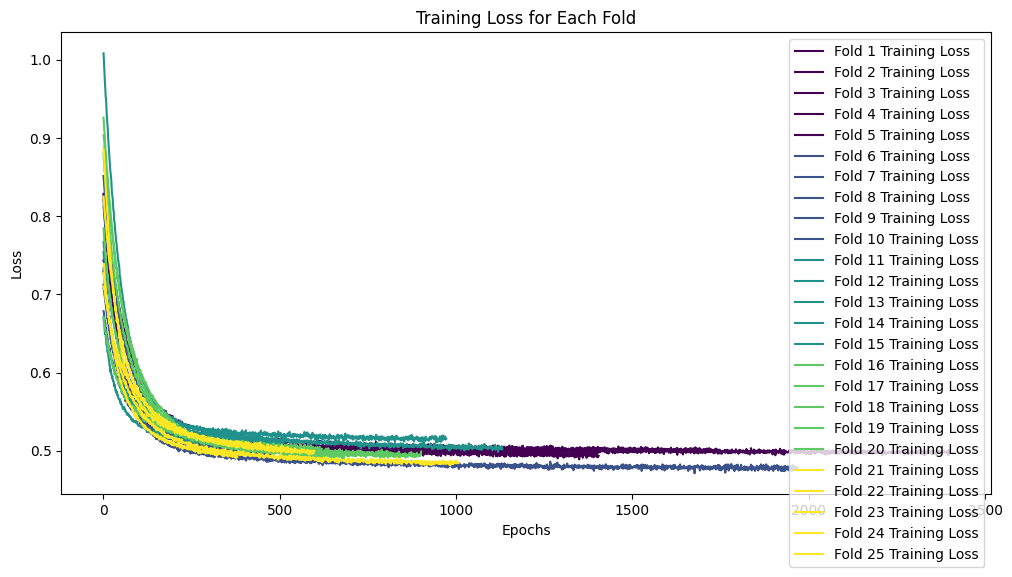

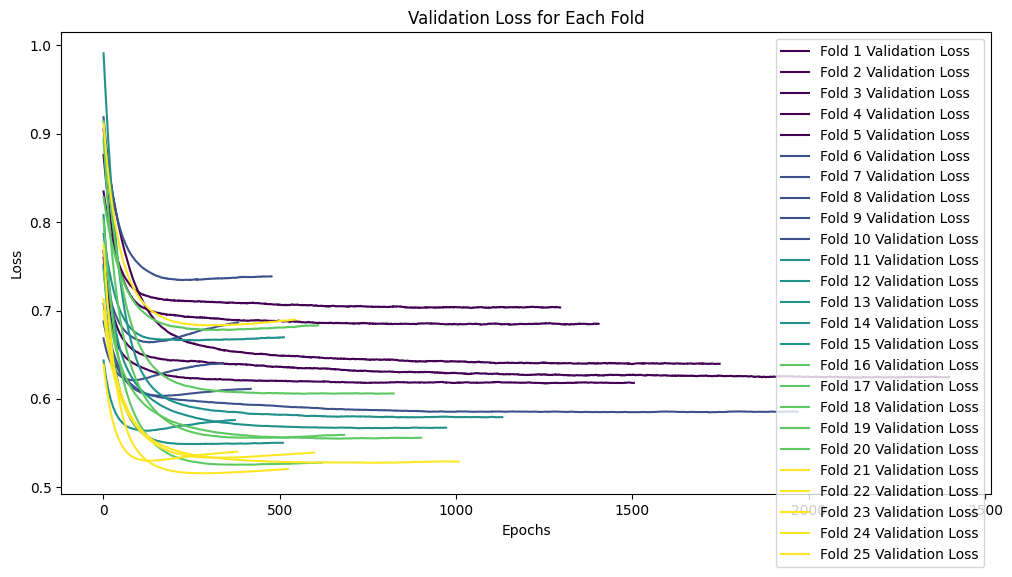

In [14]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm 


plt.figure(figsize=(12, 6))

colors = cm.viridis(np.linspace(0,1,5))

for i, train_loss in enumerate(train_loss_list):
    plt.plot(
        range(1, len(train_loss) + 1),
        train_loss,
        label=f"Fold {i+1} Training Loss",
        color=colors[i // 5],
    )
plt.title("Training Loss for Each Fold")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("result/transformer_split_train_loss.svg")
plt.show()

# Plot the validation loss for each fold
plt.figure(figsize=(12, 6))
for i, val_loss in enumerate(val_loss_list):
    plt.plot(
        range(1, len(val_loss) + 1),
        val_loss,
        label=f"Fold {i+1} Validation Loss",
        color=colors[i // 5],
    )
plt.title("Validation Loss for Each Fold")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("result/transformer_split_val_loss.svg")
plt.show()